<a href="https://colab.research.google.com/github/magenta/ddsp/blob/main/ddsp/colab/demos/timbre_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [1]:
# Copyright 2021 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP Timbre Transfer Demo

This notebook is a demo of timbre transfer using DDSP (Differentiable Digital Signal Processing).
The model here is trained to generate audio conditioned on a time series of fundamental frequency and loudness.

* [DDSP ICLR paper](https://openreview.net/forum?id=B1x1ma4tDr)
* [Audio Examples](http://goo.gl/magenta/ddsp-examples)

This notebook extracts these features from input audio (either uploaded files, or recorded from the microphone) and resynthesizes with the model.

<img src="https://magenta.tensorflow.org/assets/ddsp/ddsp_cat_jamming.png" alt="DDSP Tone Transfer" width="700">



By default, the notebook will download pre-trained models. You can train a model on your own sounds by using the [Train Autoencoder Colab](https://github.com/magenta/ddsp/blob/main/ddsp/colab/demos/train_autoencoder.ipynb).

Have fun! And please feel free to hack this notebook to make your own creative interactions.


### Instructions for running:

* Make sure to use a GPU runtime, click:  __Runtime >> Change Runtime Type >> GPU__
* Press ▶️ on the left of each of the cells
* View the code: Double-click any of the cells
* Hide the code: Double click the right side of the cell





In [2]:
#@title #Install and Import

#@markdown Install ddsp, define some helper functions, and download the model. This transfers a lot of data and _should take a minute or two_.
# print('Installing from pip package...')
# !git clone https://github.com/olaviinha/ddsp.git
# %cd ddsp
# !pip install .

In [2]:
# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import time

import crepe
import ddsp
import ddsp.training
from ddsp.colab.colab_utils import (
    auto_tune, get_tuning_factor,
    specplot, audio_bytes_to_np,
    DEFAULT_SAMPLE_RATE)
from ddsp.training.postprocessing import (
    detect_notes, fit_quantile_transform
)
import gin
# from google.colab import files
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Helper Functions
sample_rate = DEFAULT_SAMPLE_RATE  # 16000


print('Done!')

Done!


In [3]:
# Load audio file
fnames = ["dataset/wav/f1_caro_straight.wav"]
audios = []
for fname in fnames:
    with open(fname, "rb") as f:
        audio_bytes = f.read()
    file_audio = audio_bytes_to_np(audio_bytes,
                                   sample_rate=sample_rate,
                                   normalize_db=None)
    audios.append(file_audio)


Extracting audio features...
Audio features took 70.6 seconds


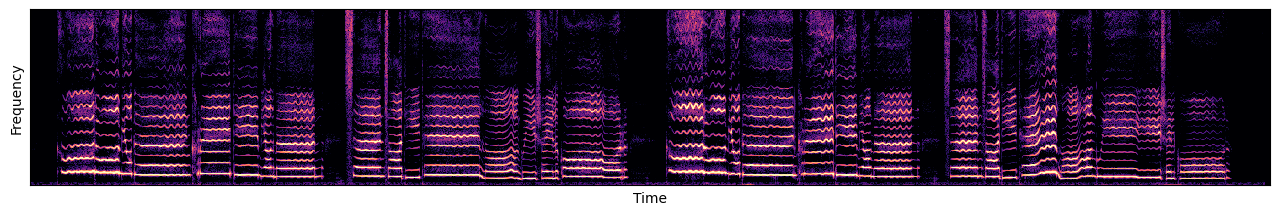

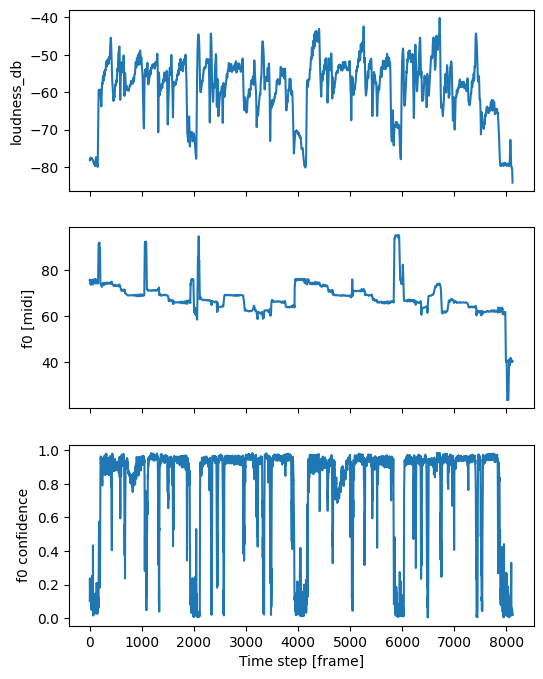

In [4]:
#@title Record or Upload Audio
#@markdown * Either record audio from microphone or upload audio from file (.mp3 or .wav)
#@markdown * Audio should be monophonic (single instrument / voice)
#@markdown * Extracts fundmanetal frequency (f0) and loudness features.

# record_or_upload = "Upload (.mp3 or .wav)"  #@param ["Record", "Upload (.mp3 or .wav)"]
#
# record_seconds =     5#@param {type:"number", min:1, max:10, step:1}
#
# if record_or_upload == "Record":
#   audio = record(seconds=record_seconds)
# else:
#   # Load audio sample here (.mp3 or .wav3 file)
#   # Just use the first file.
#   filenames, audios = upload()
audio = audios[0]
if len(audio.shape) == 1:
  audio = audio[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
specplot(audio)
# play(audio)

# Setup the session.
ddsp.spectral_ops.reset_crepe()

# Compute features.
start_time = time.time()
audio_features = ddsp.training.metrics.compute_audio_features(audio)
audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
audio_features_mod = None
print('Audio features took %.1f seconds' % (time.time() - start_time))


TRIM = -15
# Plot Features.
fig, ax = plt.subplots(nrows=3,
                       ncols=1,
                       sharex=True,
                       figsize=(6, 8))
ax[0].plot(audio_features['loudness_db'][:TRIM])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax[1].set_ylabel('f0 [midi]')

ax[2].plot(audio_features['f0_confidence'][:TRIM])
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')



In [11]:
#@title Load a model
#@markdown Run for ever new audio input
model_name = 'Flute' #@param ['Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone', 'Upload your own (checkpoint folder as .zip)']
MODEL = model_name


# def find_model_dir(dir_name):
#   # Iterate through directories until model directory is found
#   for root, dirs, filenames in os.walk(dir_name):
#     for filename in filenames:
#       if filename.endswith(".gin") and not filename.startswith("."):
#         model_dir = root
#         break
#   return model_dir

if model_name in ('Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone'):
  # Pretrained models.
  PRETRAINED_DIR = 'pretrained/' + model_name.lower()
  print('Pre-trained model saved to', PRETRAINED_DIR)
  # # Copy over from gs:// for faster loading.
  # !rm -r $PRETRAINED_DIR &> /dev/null
  # !mkdir $PRETRAINED_DIR &> /dev/null
  # GCS_CKPT_DIR = 'gs://ddsp/models/timbre_transfer_colab/2021-07-08'
  # model_dir = os.path.join(GCS_CKPT_DIR, 'solo_%s_ckpt' % model.lower())

  # !gsutil cp $model_dir/* $PRETRAINED_DIR &> /dev/null
  model_dir = PRETRAINED_DIR
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')

# else:
#   # User models.
#   UPLOAD_DIR = '/content/uploaded'
#   !mkdir $UPLOAD_DIR
#   uploaded_files = files.upload()
#
#   for fnames in uploaded_files.keys():
#     print("Unzipping... {}".format(fnames))
#     !unzip -o "/content/$fnames" -d $UPLOAD_DIR &> /dev/null
#   model_dir = find_model_dir(UPLOAD_DIR)
#   gin_file = os.path.join(model_dir, 'operative_config-0.gin')


# Load the dataset statistics.
DATASET_STATS = None
dataset_stats_file = os.path.join(model_dir, 'dataset_statistics.pkl')
print(f'Loading dataset statistics from {dataset_stats_file}')
try:
  if tf.io.gfile.exists(dataset_stats_file):
    with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
      DATASET_STATS = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))


# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size

print("===Trained model===")
print("Time Steps", time_steps_train)
print("Samples", n_samples_train)
print("Hop Size", hop_size)
print("\n===Resynthesis===")
print("Time Steps", time_steps)
print("Samples", n_samples)
print('')

gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:, :n_samples]


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)

# Build model by running a batch through it.
start_time = time.time()
_ = model(audio_features, training=False)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

Pre-trained model saved to pretrained/flute
Loading dataset statistics from pretrained/flute/dataset_statistics.pkl
===Trained model===
Time Steps 1000
Samples 64000
Hop Size 64

===Resynthesis===
Time Steps 8133
Samples 520512

Restoring model took 7.4 seconds


Autotuning... 
Inferred key: D  
Tuning offset: 7 cents


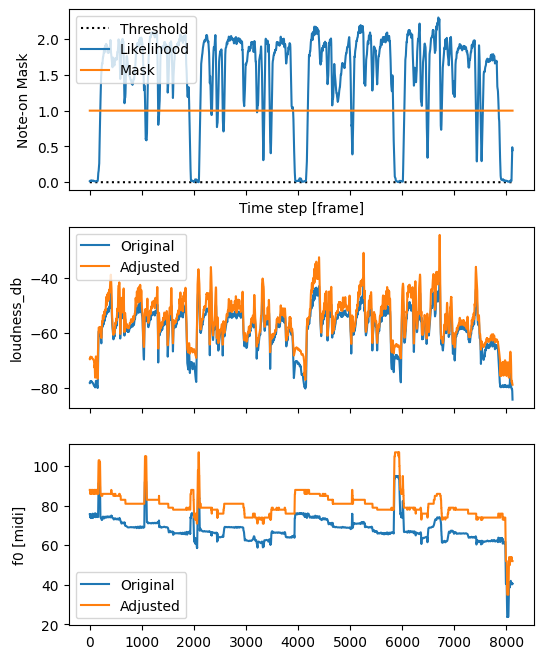

In [7]:
#@title Modify conditioning

#@markdown These models were not explicitly trained to perform timbre transfer, so they may sound unnatural if the incoming loudness and frequencies are very different then the training data (which will always be somewhat true).


#@markdown ## Note Detection

#@markdown You can leave this at 1.0 for most cases
threshold = 0 #@param {type:"slider", min: 0.0, max:2.0, step:0.01}


#@markdown ## Automatic

ADJUST = True #@param{type:"boolean"}

#@markdown Quiet parts without notes detected (dB)
quiet = 60 #@param {type:"slider", min: 0, max:60, step:1}

#@markdown Force pitch to nearest note (amount)
autotune = 1 #@param {type:"slider", min: 0.0, max:1.0, step:0.1}

#@markdown ## Manual


#@markdown Shift the pitch (octaves)
pitch_shift =  0 #@param {type:"slider", min:-2, max:2, step:1}

#@markdown Adjust the overall loudness (dB)
loudness_shift = 0 #@param {type:"slider", min:-20, max:20, step:1}


audio_features_mod = {k: v.copy() for k, v in audio_features.items()}


## Helper functions.
def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, pitch_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (pitch_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'],
                                    0.0,
                                    librosa.midi_to_hz(110.0))
  return audio_features


mask_on = None

if ADJUST and DATASET_STATS is not None:
  # Detect sections that are "on".
  mask_on, note_on_value = detect_notes(audio_features['loudness_db'],
                                        audio_features['f0_confidence'],
                                        threshold)

  if np.any(mask_on):
    # Shift the pitch register.
    target_mean_pitch = DATASET_STATS['mean_pitch']
    pitch = ddsp.core.hz_to_midi(audio_features['f0_hz'])
    mean_pitch = np.mean(pitch[mask_on])
    p_diff = target_mean_pitch - mean_pitch
    p_diff_octave = p_diff / 12.0
    round_fn = np.floor if p_diff_octave > 1.5 else np.ceil
    p_diff_octave = round_fn(p_diff_octave)
    audio_features_mod = shift_f0(audio_features_mod, p_diff_octave)


    # Quantile shift the note_on parts.
    _, loudness_norm = fit_quantile_transform(
        audio_features['loudness_db'],
        mask_on,
        inv_quantile=DATASET_STATS['quantile_transform'])

    # Turn down the note_off parts.
    mask_off = np.logical_not(mask_on)
    loudness_norm[mask_off] -=  quiet * (1.0 - note_on_value[mask_off][:, np.newaxis])
    loudness_norm = np.reshape(loudness_norm, audio_features['loudness_db'].shape)

    audio_features_mod['loudness_db'] = loudness_norm

    # Auto-tune.
    if autotune:
      f0_midi = np.array(ddsp.core.hz_to_midi(audio_features_mod['f0_hz']))
      tuning_factor = get_tuning_factor(f0_midi, audio_features_mod['f0_confidence'], mask_on)
      f0_midi_at = auto_tune(f0_midi, tuning_factor, mask_on, amount=autotune)
      audio_features_mod['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at)

  else:
    print('\nSkipping auto-adjust (no notes detected or ADJUST box empty).')

else:
  print('\nSkipping auto-adujst (box not checked or no dataset statistics found).')

# Manual Shifts.
audio_features_mod = shift_ld(audio_features_mod, loudness_shift)
audio_features_mod = shift_f0(audio_features_mod, pitch_shift)



# Plot Features.
has_mask = int(mask_on is not None)
n_plots = 3 if has_mask else 2
fig, axes = plt.subplots(nrows=n_plots,
                      ncols=1,
                      sharex=True,
                      figsize=(2*n_plots, 8))

if has_mask:
  ax = axes[0]
  ax.plot(np.ones_like(mask_on[:TRIM]) * threshold, 'k:')
  ax.plot(note_on_value[:TRIM])
  ax.plot(mask_on[:TRIM])
  ax.set_ylabel('Note-on Mask')
  ax.set_xlabel('Time step [frame]')
  ax.legend(['Threshold', 'Likelihood','Mask'])

ax = axes[0 + has_mask]
ax.plot(audio_features['loudness_db'][:TRIM])
ax.plot(audio_features_mod['loudness_db'][:TRIM])
ax.set_ylabel('loudness_db')
ax.legend(['Original','Adjusted'])

ax = axes[1 + has_mask]
ax.plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax.plot(librosa.hz_to_midi(audio_features_mod['f0_hz'][:TRIM]))
ax.set_ylabel('f0 [midi]')
_ = ax.legend(['Original','Adjusted'])


Prediction took 7.1 seconds


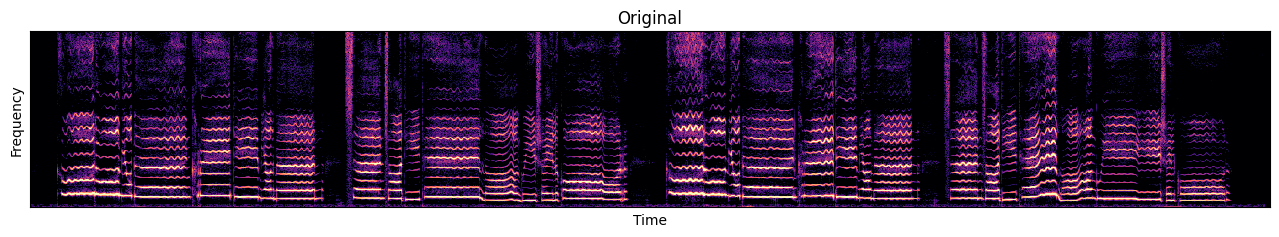

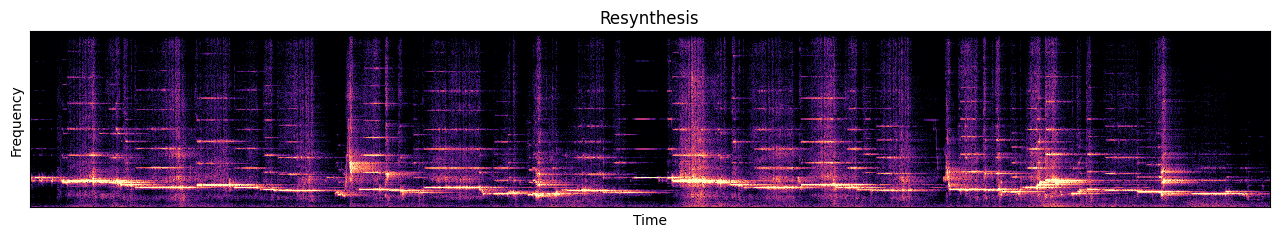

In [8]:
#@title #Resynthesize Audio

af = audio_features if audio_features_mod is None else audio_features_mod

# Run a batch of predictions.
start_time = time.time()
outputs = model(af, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
print('Prediction took %.1f seconds' % (time.time() - start_time))

# Plot
# print('Original')
# play(audio)
#
# print('Resynthesis')
# play(audio_gen)

specplot(audio)
plt.title("Original")

specplot(audio_gen)
_ = plt.title("Resynthesis")

In [9]:
import numpy as np
import io
from scipy.io import wavfile

def save_wav(array_of_floats,
             filename,
             sample_rate=16000):
    """Save an array of floats as a WAV file."""

    # If batched, take first element
    if len(array_of_floats.shape) == 2:
        array_of_floats = array_of_floats[0]

    # Clip values to [-1, 1] just in case
    array_of_floats = np.clip(array_of_floats, -1.0, 1.0)

    # Convert to 16-bit PCM
    normalizer = float(np.iinfo(np.int16).max)
    array_of_ints = np.array(
        np.asarray(array_of_floats) * normalizer, dtype=np.int16)

    # Save as WAV
    wavfile.write(filename, sample_rate, array_of_ints)
    print(f"Saved WAV file: {filename}")

In [10]:
file_name = "f1_caro_straight_"+model_name.lower()+".wav"
save_wav(audio_gen, file_name)

Saved WAV file: f1_caro_straight_flute.wav
